In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, scale
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, roc_auc_score

In [58]:
def log(x):
    if x == 0:
        return 0

    return np.log(x) if x > 0 else -np.log(np.abs(x)) - 1

In [59]:
def outliers(s):
    q25, q75 = s.quantile([0.25, 0.75])
    iqr = q75 - q25
    th_min = q25 - (iqr * 1.5)
    th_max = q75 + (iqr * 1.5)
    return (s < th_min) | (s > th_max)    

In [60]:
def plot_num_cols_hist(df):
    fig, axs = plt.subplots(3, 3, figsize=(20, 20))
    for col, ax in zip(num_cols, axs.flat):
        ax.hist(df[col], bins=60)
        ax.set_title(col)    

In [61]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time']
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating', 'income', 'app_date']
target_col = 'default'

def load_data():
    # Read data
    train_df = pd.read_csv("./train.csv")
    test_df = pd.read_csv("./test.csv")

    return train_df, test_df   

In [62]:
raw_train_df, raw_test_df = load_data()

In [63]:
def preprocess_data(train_df, test_df):
    train_df = train_df.copy()
    test_df = test_df.copy()
    
    # Mark test and train datasets
    train_df['train'] = 1
    test_df['train'] = 0
    test_df['default'] = np.nan

    # Join test and train datasets
    df = pd.concat([train_df, test_df])
    
    # Fill nans of 'education' col with most common value
    df['education'].fillna('SCH', inplace=True)

    # Parsing date
    app_date = pd.to_datetime(train_df['app_date'], format="%d%b%Y")
    time_delta = pd.datetime.now() - app_date
    df['app_date'] = time_delta.dt.days

    # Replacing binary cols with 0s and 1s
    for col in bin_cols:
        df[col] = LabelEncoder().fit_transform(df[col])

    # Replace cat. cols with dummies
    df = pd.get_dummies(df, columns=cat_cols)

    # Logarithm number cols
    for col in num_cols:
        df[col] = df[col].apply(log) 
        df[col] = scale(df[col])

    train_df = df[df['train'] == 1]
    test_df = df[df['train'] == 0]

    train_df.drop(columns=['train'], inplace=True)
    test_df.drop(columns=['train', 'default'], inplace=True)

    return train_df, test_df

In [64]:
train_df, test_df = preprocess_data(raw_train_df, raw_test_df)

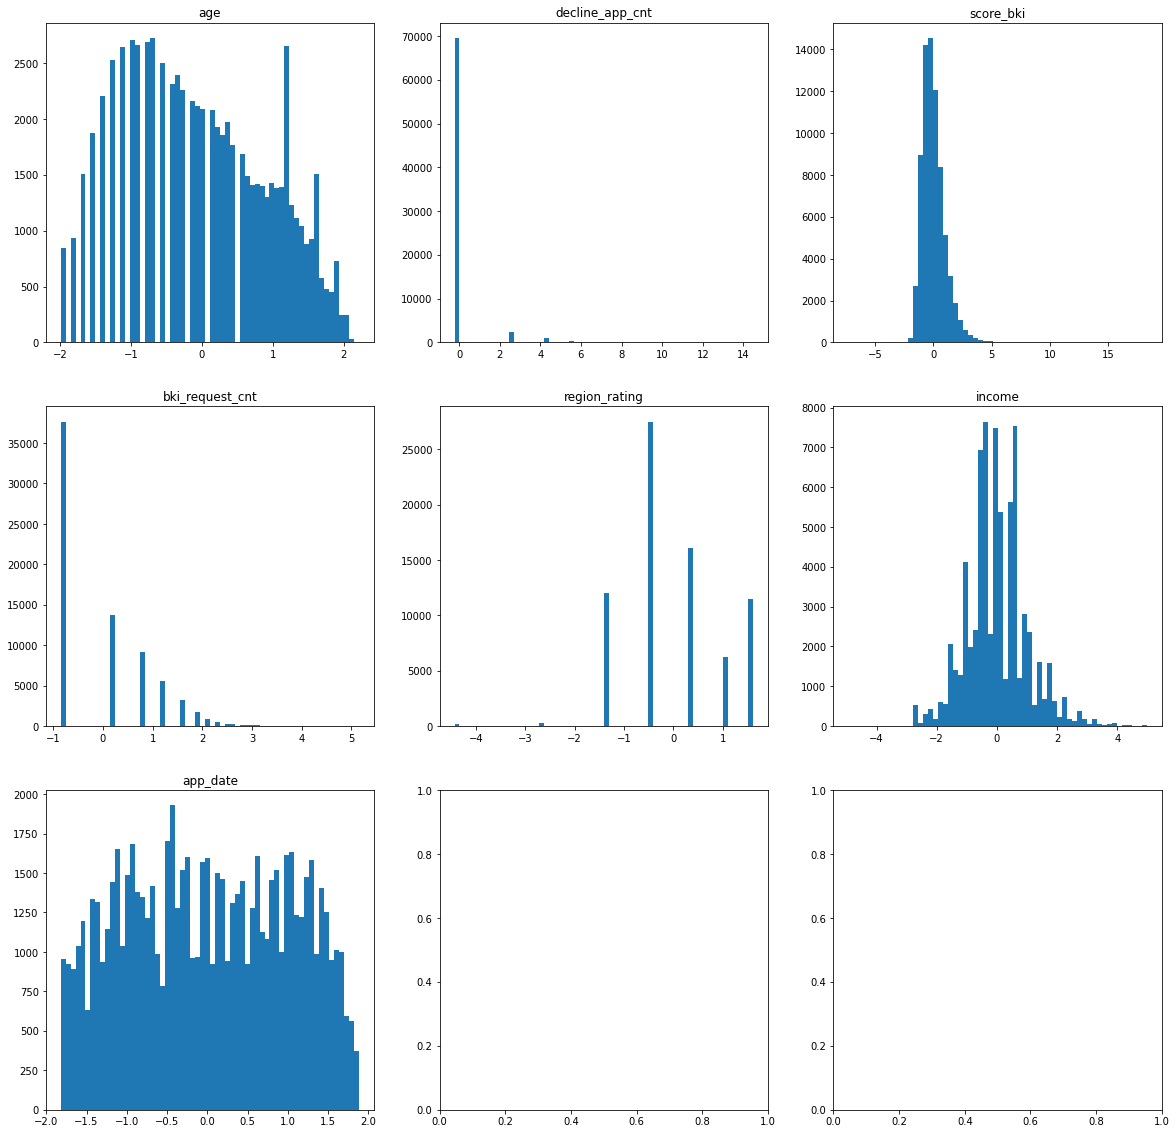

In [65]:
plot_num_cols_hist(train_df)

In [66]:
def oversample(df):
    class0 = df[df[target_col] == 0]
    class1 = df[df[target_col] == 1]
    
    c0 = class0.shape[0]
    c1 = class1.shape[0]

    diff = abs(c0 - c1)
    times = diff // min(c0, c1)

    if times > 1:
        oversamples = []
        for _ in range(times):
            if c0 > c1:
                oversamples.append(class1)   
            else:
                oversamples.append(class0)   

        df = pd.concat([df, *oversamples])


    return df

def undersample(df):
    class0 = df[df[target_col] == 0]
    class1 = df[df[target_col] == 1]

    class0_1, class0_2 = train_test_split(class0, train_size=class1.shape[0]) 

    df = pd.concat([class0_1, class1])

    return df    

def resample(df):
    # return oversample(df)
    return undersample(df)

In [67]:
resampled_train_df = resample(train_df)

In [68]:
def train_model(df):
    ignore_cols = ['client_id', target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=ignore_cols), 
        df[target_col], 
        random_state=542, 
        test_size=0.3
    )

    model = LogisticRegression(C=7.74, random_state=633, max_iter=1000)

    model.fit(X_train, y_train)

    # hyperparameters = dict(C=np.logspace(0, 4, 10), penalty=['l1', 'l2'])
    # clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)
    # best_model = clf.fit(X_train, y_train)
    # print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
    # print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

    y_pred = model.predict(X_test)

    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

    f1 = f1_score(y_test, y_pred)
    print("F1 score", f1)

    return model

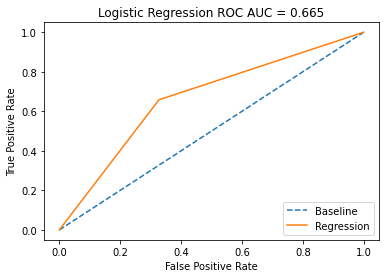

F1 score 0.6645276292335115


In [69]:
model = train_model(resampled_train_df)

In [70]:
def predict_and_save(model, df):
    y_pred = model.predict_proba(df.drop(columns=['client_id']))

    sub_df = test_df[['client_id']]
    sub_df['default'] = list(map(lambda x: x[1], y_pred))
    sub_df.to_csv('submissions.csv', index=False)
    return sub_df

In [71]:
predict_and_save(model, test_df)

,client_id,default
0,74835,0.241800
1,17527,0.750981
2,75683,0.286752
3,26883,0.427039
4,28862,0.151820
...,...,...
36344,83775,0.759074
36345,106254,0.097733
36346,81852,0.752782
36347,1971,0.530143
